In [ ]:
!pip install shap lime xgboost tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=0a82381583724af65391f40ea6f24e53209ac736675d7053b33a3bb05a3cc489
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


#STEP 1 — Load & Inspect Data

In [ ]:
import pandas as pd

df = pd.read_csv("/content/NN1.csv")

df.head()

,datetimeUtc,no,no2,nox,relativehumidity,temperature,wind_direction,wind_speed,hour,day,weekday
0,2026-01-26 00:15:00+00:00,12.7,37.2,0.0300,97.0,7.3,359.0,0.3,0,26,0
1,2026-01-26 00:30:00+00:00,21.5,32.6,0.0351,97.0,7.2,359.0,0.3,0,26,0
2,2026-01-26 00:45:00+00:00,40.9,31.3,0.0509,98.0,7.1,359.0,0.3,0,26,0
3,2026-01-26 01:00:00+00:00,22.9,28.4,0.0346,98.0,7.1,359.0,0.3,1,26,0
4,2026-01-26 01:15:00+00:00,11.3,31.7,0.0260,97.0,7.0,359.0,0.3,1,26,0


#STEP 2 — CLEAN DATETIME (MOST IMPORTANT FIX)

In [ ]:
df['datetimeUtc'] = pd.to_datetime(df['datetimeUtc'])

In [ ]:
df['hour'] = df['datetimeUtc'].dt.hour
df['day'] = df['datetimeUtc'].dt.day
df['month'] = df['datetimeUtc'].dt.month
df['weekday'] = df['datetimeUtc'].dt.weekday

df.drop('datetimeUtc', axis=1, inplace=True)

In [ ]:
df.fillna(df.mean(), inplace=True)

#🚀 STEP 4 — Define Target

In [ ]:
target = "nox"

In [ ]:
X = df.drop(target, axis=1)
y = df[target]

#🚀 STEP 5 — Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#🥇 MODEL 1 — Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=300, max_depth=12)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

In [ ]:
from sklearn.metrics import r2_score

print("RF R2:", r2_score(y_test, rf_pred))

RF R2: 0.9936321423617341


#MATPLOTLIB VISUALIZATION

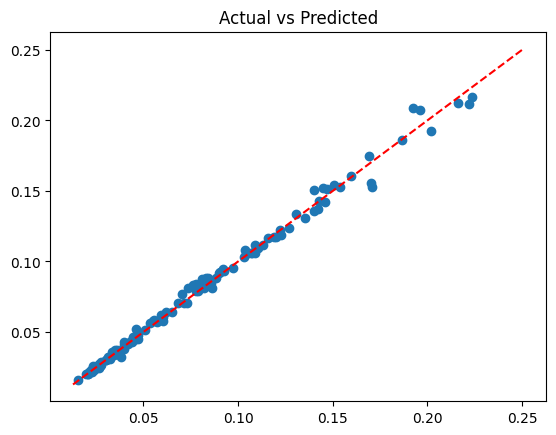

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test, rf_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title("Actual vs Predicted")
plt.show()

#t-SNE Visualization

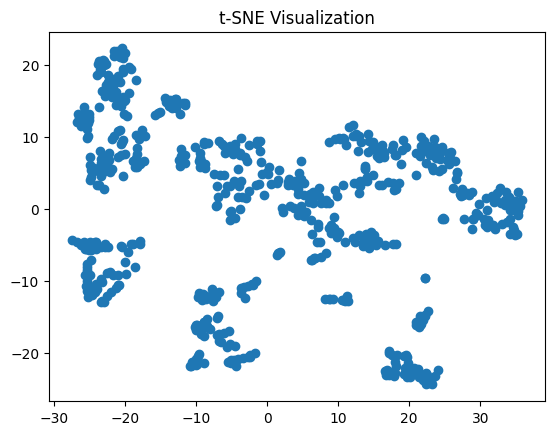

In [ ]:
tsne = TSNE(n_components=2)

sample_size = min(3000, len(X))  # automatically choose safe size
X_sample = X.sample(sample_size, random_state=42)

X_embedded = tsne.fit_transform(X_sample)

plt.scatter(X_embedded[:,0], X_embedded[:,1])
plt.title("t-SNE Visualization")
plt.show()

#SHAP Explainability

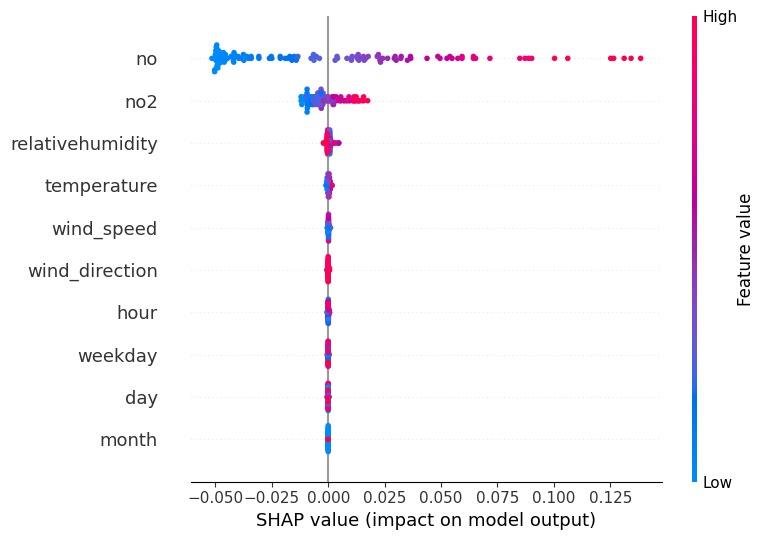

In [ ]:
import shap

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

#LIME Explanation

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

lime_exp = LimeTabularExplainer(
    X_train.values,
    feature_names=X.columns,
    mode="regression"
)

exp = lime_exp.explain_instance(X_test.iloc[0].values, rf.predict)
exp.show_in_notebook()

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


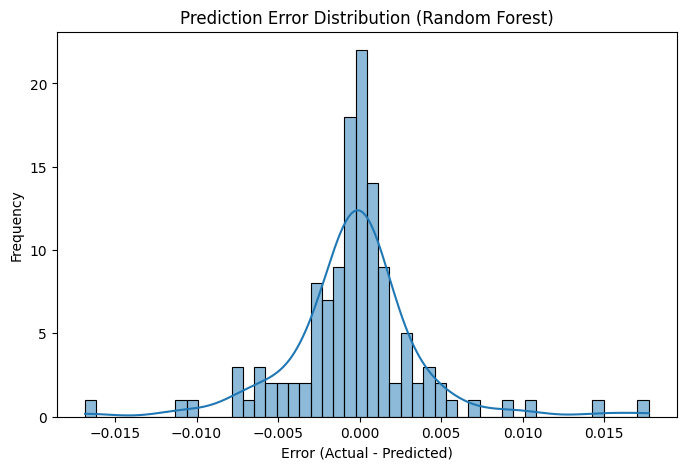

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

errors = y_test - rf_pred

plt.figure(figsize=(8,5))
sns.histplot(errors, bins=50, kde=True)
plt.title("Prediction Error Distribution (Random Forest)")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()

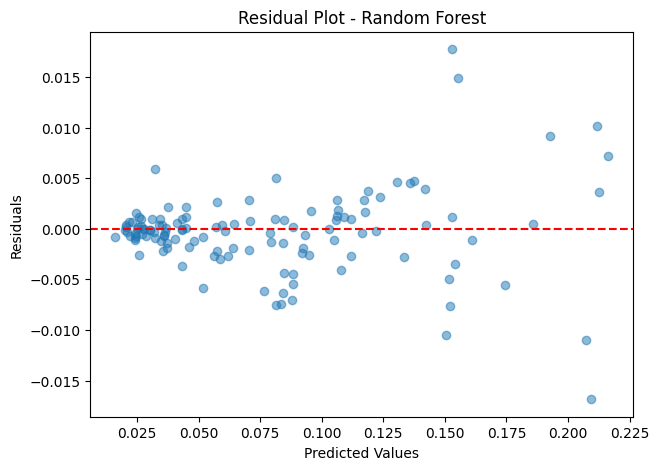

In [ ]:
plt.figure(figsize=(7,5))
plt.scatter(rf_pred, errors, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot - Random Forest")
plt.show()

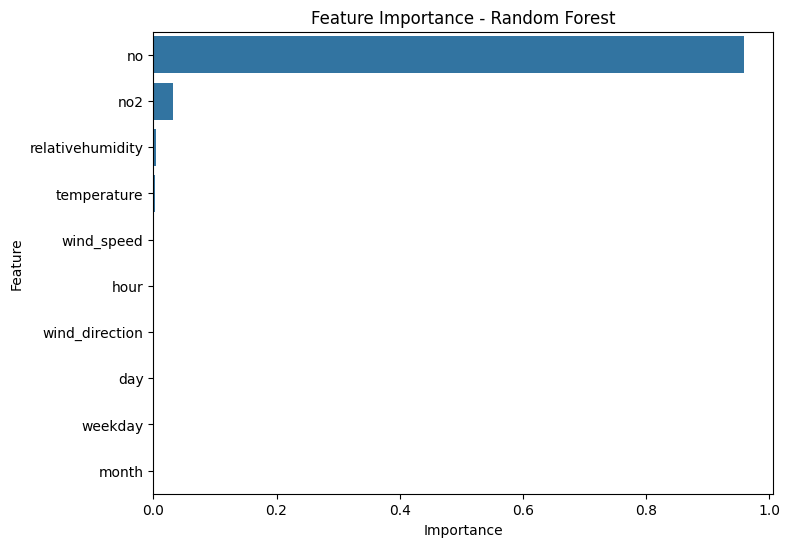

In [ ]:
import pandas as pd

importance = rf.feature_importances_
features = X.columns

imp_df = pd.DataFrame({
    "Feature": features,
    "Importance": importance
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x="Importance", y="Feature", data=imp_df)
plt.title("Feature Importance - Random Forest")
plt.show()

In [ ]:
import pickle

pickle.dump(rf, open("nox_rf_model.pkl", "wb"))
print("Model saved successfully")

Model saved successfully
